In [1]:
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader


## Data
- [ml-latest-small](https://grouplens.org/datasets/movielens/) 



In [2]:
raw_data = pd.read_csv("../data/ml-latest-small/ratings.csv")

item2idx, idx2item = {}, {}
user2idx, idx2user = {}, {}
id2title = {}

for idx, user_id in enumerate(np.unique(raw_data["userId"])):
    user2idx[user_id] = idx
    idx2user[idx] = user_id
for idx, item_id in enumerate(np.unique(raw_data["movieId"])):
    item2idx[item_id] = idx
    idx2item[idx] = item_id

# make index data
index_data = raw_data.copy()
index_data["userId"] = raw_data["userId"].apply(lambda idx:user2idx[idx])
index_data["movieId"] = raw_data["movieId"].apply(lambda idx:item2idx[idx])

n_user = np.unique(raw_data["userId"]).shape[0]
n_item = np.unique(raw_data["movieId"]).shape[0]

In [3]:
print(n_user, n_item)

610 9724


In [4]:
class MovieLensDataset(Dataset):
    def __init__(self, data, n_item, n_user, IsItem:bool=True):
        self.data = data
        self.IsItem = IsItem
        self.i_rating_matrix = np.zeros((n_item, n_user))
        self.u_rating_matrix = np.zeros((n_user, n_item))

        self.__make_rating_mat__()

    def __make_rating_mat__(self):
        for user, item, rating in zip(self.data.userId, self.data.movieId, self.data.rating):
            self.i_rating_matrix[item][user] = rating
            self.u_rating_matrix[user][item] = rating

    def __len__(self):
        if self.IsItem:
            return len(self.i_rating_matrix)
        return len(self.u_rating_matrix)

    def __getitem__(self, index):
        if self.IsItem:
            return torch.tensor(self.i_rating_matrix[index]).float()
        return torch.tensor(self.u_rating_matrix[index]).float()

## Model
- I-AutoRec -> (item, user) rating matrix를 입력으로 줌
- U-AutoRec -> (user, item) rating matrix를 입력으로 줌

In [5]:
class AutoRec(nn.Module):
    def __init__(self, n_hidden, n_input, dropout_rate, custom:bool=False):
        super(AutoRec, self).__init__()
        self.custom = custom

        self.encoder = nn.Linear(n_input, n_hidden)
        self.hidden_enc = nn.Linear(n_hidden, n_hidden//2)
        self.b1 = nn.Parameter(torch.ones(n_hidden))
        self.sigmoid = nn.Sigmoid()

        self.hidden_dec = nn.Linear(n_hidden//2, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_input)
        self.b2 = nn.Parameter(torch.ones(n_input))
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, mat):
        if self.custom:
            hidden = self.dropout(self.hidden_enc(self.sigmoid(self.encoder(mat) + self.b1)))
            out = self.decoder(self.sigmoid(self.hidden_dec(hidden))) + self.b2
        else:
            hidden = self.dropout(self.sigmoid(self.encoder(mat) + self.b1))
            out = self.decoder(hidden) + self.b2

        return out

## Train

In [31]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for row in dataloader:
        row = row.to(device)
        out = model(row)

        non_mask = row != 0

        loss = criterion(out[non_mask], row[non_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(dataloader)

def eval(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0


    with torch.no_grad():
        for row in dataloader:
            row = row.to(device)
            non_mask = row != 0

            out = model(row)
            
            total_loss += criterion(out[non_mask], row[non_mask]).item()

    return total_loss/len(dataloader)

In [57]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_epochs = 100
batch_size = 256
n_hidden = 128
lr = 0.005

In [58]:
train_data, test_data = train_test_split(index_data, train_size=0.9)

train_dataset = MovieLensDataset(train_data, n_item, n_user, IsItem=True)  # u-AutoRec : IsItem=False, i-AutoRec : IsItem=True
test_dataset = MovieLensDataset(test_data, n_item, n_user, IsItem=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [59]:
model = AutoRec(n_hidden, n_user, 0.5, custom=False) # n_input을 u-AutoRec : n_item, i-AutoRec : n_user
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=lr)

In [60]:
all_train_loss = []
all_valid_loss = []

for epoch in range(1, n_epochs+1):
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss = eval(model, test_dataloader, criterion, device)

    all_train_loss.append(train_loss)
    all_valid_loss.append(valid_loss)

    print(f'EPOCH : {epoch:2} | Train Loss : {train_loss:.6f} | Valid Loss : {valid_loss:.6f}')


EPOCH :  1 | Train Loss : 1.699419 | Valid Loss : 1.556843
EPOCH :  2 | Train Loss : 1.216042 | Valid Loss : 1.403372
EPOCH :  3 | Train Loss : 1.123337 | Valid Loss : 1.270255
EPOCH :  4 | Train Loss : 0.992500 | Valid Loss : 1.182619
EPOCH :  5 | Train Loss : 0.948138 | Valid Loss : 1.142816
EPOCH :  6 | Train Loss : 0.901724 | Valid Loss : 1.000400
EPOCH :  7 | Train Loss : 0.838633 | Valid Loss : 0.915078
EPOCH :  8 | Train Loss : 0.816193 | Valid Loss : 0.884831
EPOCH :  9 | Train Loss : 0.784483 | Valid Loss : 0.874956
EPOCH : 10 | Train Loss : 0.783273 | Valid Loss : 0.847794
EPOCH : 11 | Train Loss : 0.768034 | Valid Loss : 0.804214
EPOCH : 12 | Train Loss : 0.722806 | Valid Loss : 0.752760
EPOCH : 13 | Train Loss : 0.693242 | Valid Loss : 0.765695
EPOCH : 14 | Train Loss : 0.682633 | Valid Loss : 0.761364
EPOCH : 15 | Train Loss : 0.689780 | Valid Loss : 0.725351
EPOCH : 16 | Train Loss : 0.671442 | Valid Loss : 0.715867
EPOCH : 17 | Train Loss : 0.651141 | Valid Loss : 0.6920

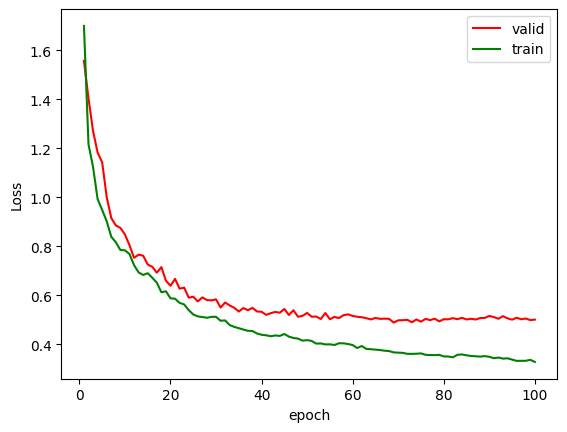

In [61]:
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(range(1,n_epochs+1), all_valid_loss, color = "red", label='valid') 
plt.plot(range(1,n_epochs+1), all_train_loss, color = "green", label='train')
plt.legend()

#### User/item 비교

In [62]:
train_dataset = MovieLensDataset(train_data, n_item, n_user, IsItem=False)  # u-AutoRec : IsItem=False, i-AutoRec : IsItem=True
test_dataset = MovieLensDataset(test_data, n_item, n_user, IsItem=False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [63]:
model = AutoRec(n_hidden, n_item, 0.5, custom=False) # n_input을 u-AutoRec : n_item, i-AutoRec : n_user
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=lr)

In [64]:
u_all_train_loss = []
u_all_valid_loss = []

for epoch in range(1, n_epochs+1):
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss = eval(model, test_dataloader, criterion, device)

    u_all_train_loss.append(train_loss)
    u_all_valid_loss.append(valid_loss)

    print(f'EPOCH : {epoch:2} | Train Loss : {train_loss:.6f} | Valid Loss : {valid_loss:.6f}')


EPOCH :  1 | Train Loss : 6.535674 | Valid Loss : 3.475558
EPOCH :  2 | Train Loss : 3.177477 | Valid Loss : 1.594727
EPOCH :  3 | Train Loss : 1.622581 | Valid Loss : 1.599869
EPOCH :  4 | Train Loss : 1.627522 | Valid Loss : 1.845854
EPOCH :  5 | Train Loss : 1.519106 | Valid Loss : 1.664866
EPOCH :  6 | Train Loss : 1.290507 | Valid Loss : 1.458703
EPOCH :  7 | Train Loss : 1.152998 | Valid Loss : 1.342310
EPOCH :  8 | Train Loss : 1.128370 | Valid Loss : 1.291671
EPOCH :  9 | Train Loss : 1.082734 | Valid Loss : 1.265144
EPOCH : 10 | Train Loss : 1.046065 | Valid Loss : 1.249657
EPOCH : 11 | Train Loss : 1.023507 | Valid Loss : 1.246771
EPOCH : 12 | Train Loss : 1.022998 | Valid Loss : 1.250293
EPOCH : 13 | Train Loss : 0.994540 | Valid Loss : 1.255960
EPOCH : 14 | Train Loss : 0.972708 | Valid Loss : 1.257055
EPOCH : 15 | Train Loss : 0.939959 | Valid Loss : 1.252039
EPOCH : 16 | Train Loss : 0.937809 | Valid Loss : 1.243119
EPOCH : 17 | Train Loss : 0.955453 | Valid Loss : 1.2359

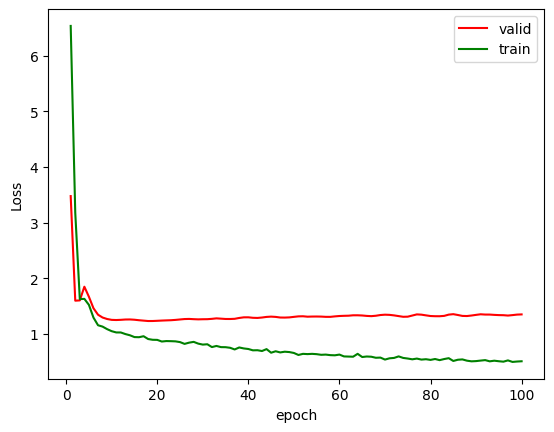

In [65]:
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(range(1,n_epochs+1), u_all_valid_loss, color = "red", label='valid') 
plt.plot(range(1,n_epochs+1), u_all_train_loss, color = "green", label='train')
plt.legend()

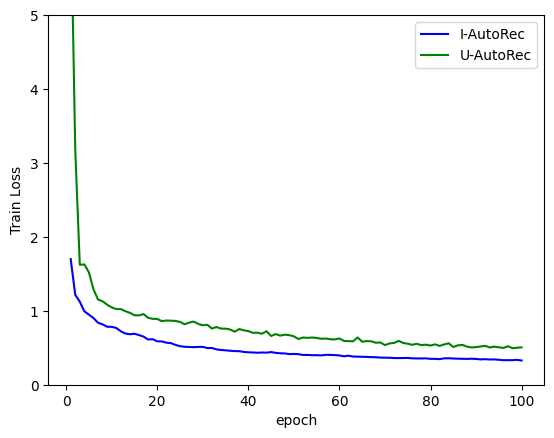

In [66]:
plt.xlabel("epoch")
plt.ylabel("Train Loss")
plt.plot(range(1,n_epochs+1), all_train_loss, color = "blue", label='I-AutoRec') 
plt.plot(range(1,n_epochs+1), u_all_train_loss, color = "green", label='U-AutoRec')
plt.ylim(0,5)
plt.legend()

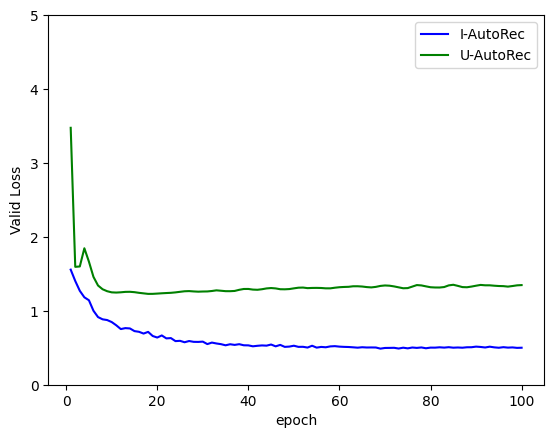

In [67]:
plt.xlabel("epoch")
plt.ylabel("Valid Loss")
plt.plot(range(1,n_epochs+1), all_valid_loss, color = "blue", label='I-AutoRec') 
plt.plot(range(1,n_epochs+1), u_all_valid_loss, color = "green", label='U-AutoRec')
plt.ylim(0,5)
plt.legend()

#### MF와 비교

In [68]:
class MFDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.user = torch.tensor(data.userId.reset_index(drop=True))
        self.item = torch.tensor(data.movieId.reset_index(drop=True))
        self.rating = torch.tensor(data.rating.reset_index(drop=True)).float()
    
    def __len__(self) -> int:
        return (len(self.user))

    def __getitem__(self, idx):
        return self.user[idx], self.item[idx], self.rating[idx] 

In [19]:
class MF(nn.Module):
    def __init__(self, n_user: int, n_item:int, n_factor:int, mu:float):
        super().__init__()
        self.P = nn.Embedding(n_user, n_factor) # user x factor
        self.Q = nn.Embedding(n_item, n_factor) # itme x factor
        self.user_bias = nn.Embedding(n_user, 1) # user x 1
        self.item_bias = nn.Embedding(n_item, 1) # item x 1
        self.mu = mu

    def forward(self, user_id: torch.tensor, item_id: torch.tensor):
        P_u = self.P(user_id) # 1 x factor
        Q_i = self.Q(item_id) # 1 x factor
        b_u = self.user_bias(user_id) # 1x1
        b_i = self.item_bias(item_id) # 1x1

        out = torch.sum(P_u*Q_i, axis=1) + torch.squeeze(b_u) + torch.squeeze(b_i) + self.mu
        return out.view(-1)

In [20]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    train_loss = 0

    for user, item, rating in dataloader:
        user = user.to(device)
        item = item.to(device)
        rating = rating.to(device)
        
        out = model(user, item)
        loss = criterion(out, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(dataloader)

def eval(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for user, item, rating in dataloader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)

            out = model(user, item)
            loss = criterion(out, rating)
            test_loss += loss.item()

    return test_loss / len(dataloader)

In [21]:
#Hyper parameters
device = 'cpu'
n_epochs = 100
batch_size = 256
n_factor = 64
lr = 0.005

In [22]:
global_mu = np.mean(train_data.rating)
train_dataset = MFDataset(train_data)
test_dataset = MFDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

model = MF(n_user, n_item, n_factor, global_mu)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)


In [23]:
MF_all_train_loss = []
MF_all_valid_loss = []

for epoch in range(1, n_epochs+1):
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss = eval(model, test_dataloader, criterion, device)

    MF_all_train_loss.append(train_loss)
    MF_all_valid_loss.append(valid_loss)

    print(f'EPOCH : {epoch:2} | Train Loss : {train_loss:.6f} | Valid Loss : {valid_loss:.6f}')


EPOCH :  1 | Train Loss : 52.900732 | Valid Loss : 41.983952
EPOCH :  2 | Train Loss : 23.360158 | Valid Loss : 29.603502
EPOCH :  3 | Train Loss : 11.940947 | Valid Loss : 22.861295
EPOCH :  4 | Train Loss : 6.706358 | Valid Loss : 18.792272
EPOCH :  5 | Train Loss : 4.069423 | Valid Loss : 16.162724
EPOCH :  6 | Train Loss : 2.643746 | Valid Loss : 14.355278
EPOCH :  7 | Train Loss : 1.825602 | Valid Loss : 13.067585
EPOCH :  8 | Train Loss : 1.332224 | Valid Loss : 12.097825
EPOCH :  9 | Train Loss : 1.021161 | Valid Loss : 11.363234
EPOCH : 10 | Train Loss : 0.819988 | Valid Loss : 10.778493
EPOCH : 11 | Train Loss : 0.688216 | Valid Loss : 10.303593
EPOCH : 12 | Train Loss : 0.605469 | Valid Loss : 9.908582
EPOCH : 13 | Train Loss : 0.556640 | Valid Loss : 9.562039
EPOCH : 14 | Train Loss : 0.537162 | Valid Loss : 9.267809
EPOCH : 15 | Train Loss : 0.543629 | Valid Loss : 8.950473
EPOCH : 16 | Train Loss : 0.554540 | Valid Loss : 8.682481
EPOCH : 17 | Train Loss : 0.559609 | Valid

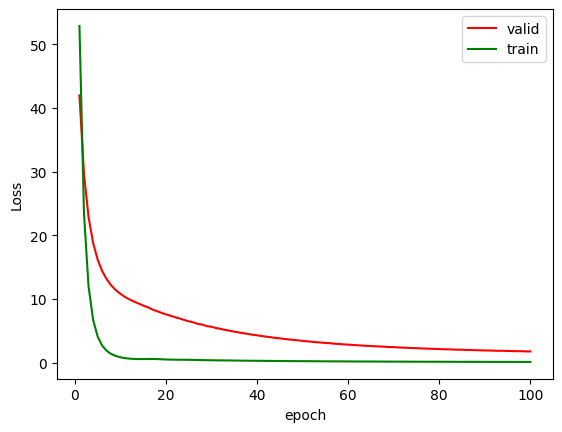

In [24]:
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(range(1,n_epochs+1), MF_all_valid_loss, color = "red", label='valid') 
plt.plot(range(1,n_epochs+1), MF_all_train_loss, color = "green", label='train')
plt.legend()

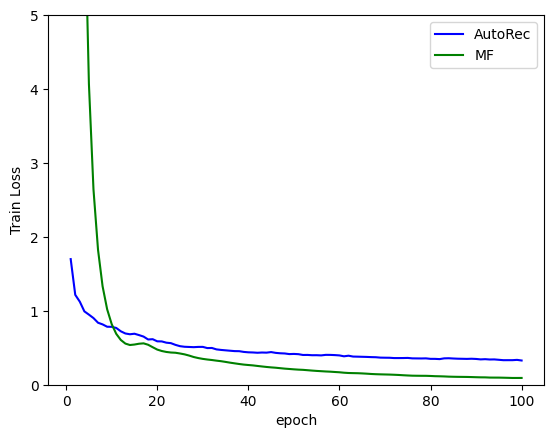

In [69]:
plt.xlabel("epoch")
plt.ylabel("Train Loss")
plt.plot(range(1,n_epochs+1), all_train_loss, color = "blue", label='AutoRec') 
plt.plot(range(1,n_epochs+1), MF_all_train_loss, color = "green", label='MF')
plt.ylim(0,5)
plt.legend()

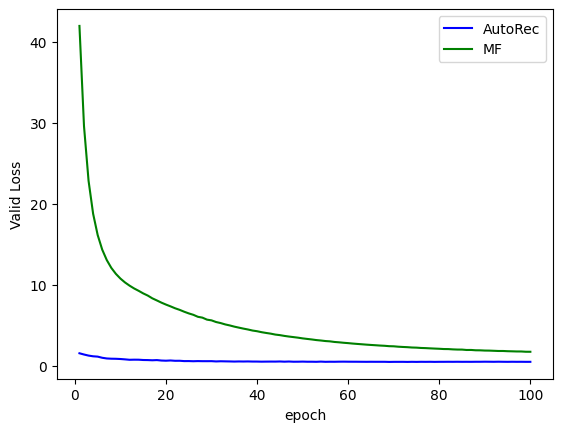

In [70]:
plt.xlabel("epoch")
plt.ylabel("Valid Loss")
plt.plot(range(1,n_epochs+1), all_valid_loss, color = "blue", label='AutoRec') 
plt.plot(range(1,n_epochs+1), MF_all_valid_loss, color = "green", label='MF')
# plt.ylim(0,5)
plt.legend()